## Importy

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def drawdemp(random_sample, sub=None, title=None,  xlim_min=None, xlim_max=None, line_style=""):
    """Draws CDF for the given random_sample."""
    xs = np.array(random_sample, dtype=float)
    xs.sort()
    step = (xs[-1] - xs[0]) / xs.size
    xs = np.insert(xs, 0, xs[0] - step)
    xs = np.insert(xs, xs.size, xs[-1] + step)
    ys = np.linspace(0, 1, xs.size - 1)

    fig, ax = plt.subplots()
    ax.hlines(y=ys, xmin=xs[:-1], xmax=xs[1:])
    ax.vlines(x=xs[1:-1], ymin=ys[:-1], ymax=ys[1:], linestyle='dashed')
    ax.set_xlim(min(xs), max(xs))
    plt.xlabel("x")
    plt.ylabel("F(x)")
    if xlim_min:
        ax.set_xlim(xlim_min, max(xs))
    if xlim_max:
        ax.set_xlim(min(xs), xlim_max)
    if xlim_min and xlim_max:
        ax.set_xlim(xlim_min, xlim_max)
    if sub:
        plt.plot(xs, [sub(i) for i in xs], line_style)
    if title:
        plt.title(title)
    plt.show()
    
def empchar(X, t):
    """Characteristic function"""
    X_exp = [np.exp(complex(0, 1) * t * j) for j in X]
    return sum(X_exp) / len(X_exp)
    
def plot_2d_complex2(fun, xs=np.arange(0, 1, 0.01)):
    """Plots real and complex part of fun."""
    X_c = [fun(i) for i in xs]
    ys = [i.real for i in X_c]
    zs = [i.imag for i in X_c]
    plt.figure(figsize=(10, 4))
    plt.plot(xs, ys)
    plt.title("real")
    plt.show()
    plt.figure(figsize=(10, 4))
    plt.plot(xs, zs)
    plt.title("imag")
    plt.show()

## Implementacja generatora z rozkładu Cantora

### Teoria

**Zbiór Cantora** to podzbiór prostej rzeczywistej opisany w 1883 przez niemieckiego matematyka Georga Cantora. Zbiór ten odkrył w 1875 Henry John Stephen Smith. Jest on najprostszym przykładem fraktala. Poczas konstruowania tego zbioru dzielimy wybrany odcinek na trzy części, po czym przeprowadzamy podział znowu dla prawej oraz lewej części. Kontunuujemy aż do uzyskania pożądanego stopnia rekuencji. 

**Funcja Cantora** jest funkcją stałą w obszarach nie należących do zbioru Cantora (jej pochodna jest równa zero w tych obszarach). Jest to funkcja ciągła lecz nie bezwględnie ciągła. Na tej funkcji można opisać probabilistyczny **rozkład Cantora**.

**Rozkład Cantora** którego dystrybuantą jest funkcja Cantora jest przykładem rozkładu singularnego. Jego dystrybuanta nie jest schodkowa, więc nie może on być rozkładem dyskretnym, jednakże funkcja Cantora nie może zostać przedstawiona jako całka funkcji gęstości prawdopodobieństwa, stąd też nie należy on do rodziny rozkładów ciągłych.


### Baza do implementacji
Jeżeli $x \in C$, gdzie $C$ jest zbiorem Cantora to wiemy, że x posiada specyficzną reprezentację w systemie trójkowym, mianowicie:
$$x = \sum_{i=1}^{\infty} \frac{x_i}{3^i}, $$
gdzie $x_i \in \{0, 2\}$. 
Na postawie tej definicji możemy zbudować nasz generator liczb z rozkładu Cantora. Potrzebujemy liczby $x_i$, która przyjmuje dwie wartości z prawdopodobieństwem $\frac{1}{2}$ każda. Te wartości mogą być wartościami ze zbioru $\{0, 2\}$ jak podane w powyższym wzorze, ale także z $\{0, 1\}$. Wtedy powyższy zbiór zamienia się na:
$$x = 2 \cdot \sum_{i=1}^{\infty} \frac{x_i}{3^i}, $$
gdzie $x \in \{0, 1\}$. Możemy zauważyć, że na zmienną $x_i$ możemy również patrzeć jak na zmienną losową z rozkładu Bernouliego z pr. $\frac{1}{2}$.



### Implementacja
Widzimy, że we wzorze pojawia się suma nieskończona która jest oczywiście niemożliwa w implementacji. W kodzie wprowadzimy więc argument prec który pozwoli na modyfikowanie rozdzielczości przez użytkownika. 
W celu usprawnienia implementacji można zauważyć także inny ciekawy fakt: nie musimy generować wielu liczb pseudolosowych. Jeżeli wygenerujemy jedną liczbę z rozkładu jednostajnego na przedziale $(0, 1)$ i pomnożymy ją przez dużą liczbę (w naszym wypadku $2^{prec}$) możemy kolejno "ściągać" wierzchnie warstwy tej liczby dzieląc ją przez dwa i zaokrąglając w dół. Naszą liczbę ze zbioru $\{0, 1\}$ uzyskamy jak można się spodziewać biorąc resztę z dzielenia przez 2. Dla liczby całkowitej która pochodzi z rozkładu jednostajnego na przedziale $(0, 2^{prec})$. Będzie to z równym prawdopodobieństwem zero lub jeden.

In [3]:
def cantor_gen(n, prec=60):
    y = np.zeros(n)
    x = (2**prec)*np.random.uniform(size=n)
    for i in range(prec):
        y = np.add(y , 2*(x % 2))/3
        x = np.floor(x/2)
    return y

In [4]:
data = cantor_gen(100000)

## Wykresy dystrybuanty empirycznej i teoretycznej

In [5]:
def cantor_fun(x, n=20):
    if n == 0:
        return x
    if 0 <= x <= 1/3:
        return 1/2*cantor_fun(3*x, n-1)
    elif 1/3 < x <= 2/3:
        return 1/2
    elif 2/3 < x <= 1:
        return 1/2 + 1/2*cantor_fun(3*x-2, n-1)

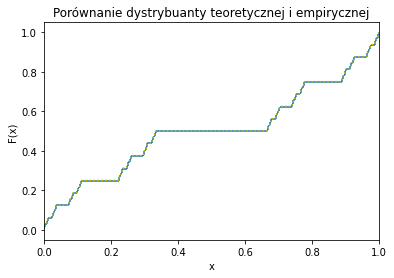

In [8]:
drawdemp(data, sub= lambda x : cantor_fun(x, n=100), title='Porównanie dystrybuanty teoretycznej i empirycznej', line_style="y:")

## Funkcja charakterystyczna

Funkcja charakterystyczna rozkładu Cantora jest dana wzorem
$$\varphi(t) = e^{it/2} \prod_{k=1}^{\infty}{\cos\left(\frac{t}{3^k}\right)}.$$ 

In [9]:
def cantor_cf(t, prec=60):
    y = np.exp(complex(0, 1)*t/2)
    for i in range(1, prec+1):
        y *= np.cos(t/3**i)
    return y

Teoretyczna funkcja charakterystyczna dla precyzji równej 60

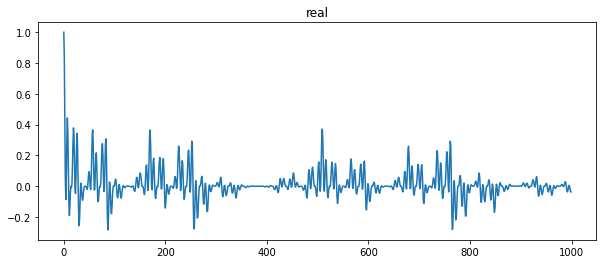

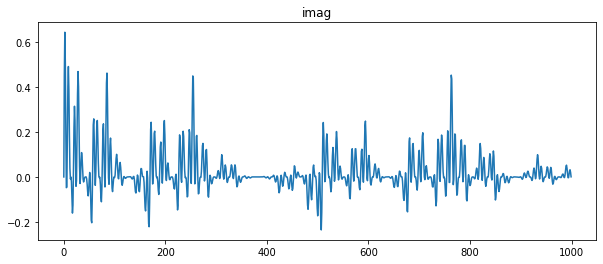

In [10]:
ts = np.arange(0, 1000, 1)
plot_2d_complex2(cantor_cf, xs=ts)

Empiryczna funkcja charakterystyczna dla precyzji równej 60

In [11]:
data = cantor_gen(10000)

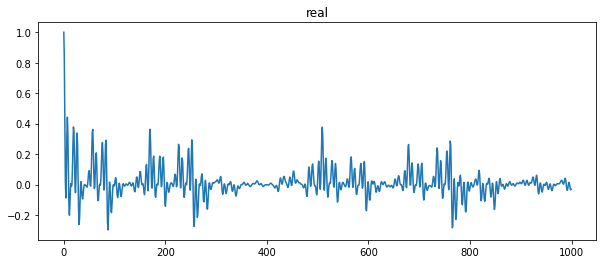

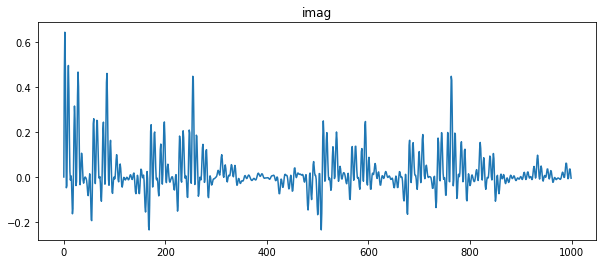

In [14]:
ts = np.arange(0, 1000, 1)
plot_2d_complex2(lambda x : empchar(data, x), xs=ts)

Empiryczna funkcja charakterystyczna dla precyzji równej 54

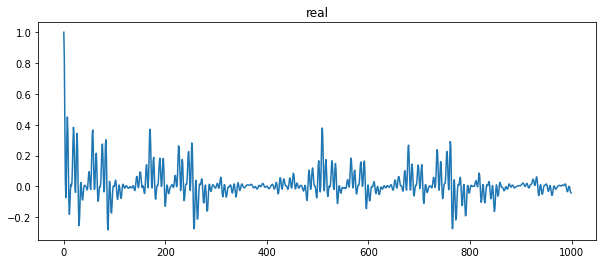

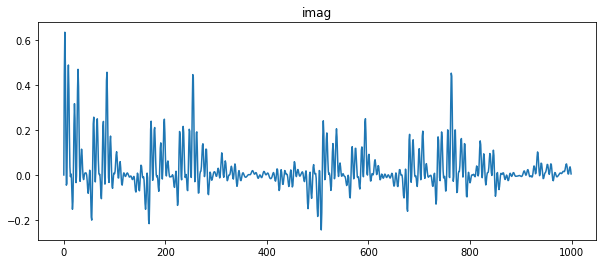

In [ ]:
data2 = cantor_gen(10000, 54)
plot_2d_complex2(lambda x : empchar(data2, x), xs=ts)

Empiryczna funkcja charakterystyczna dla precyzji równej 15

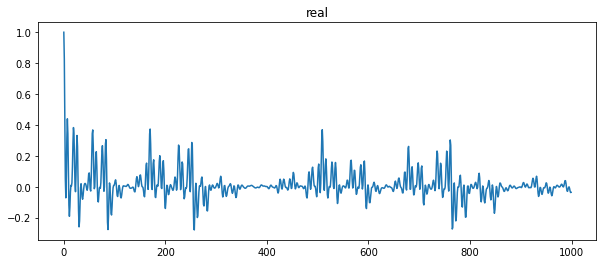

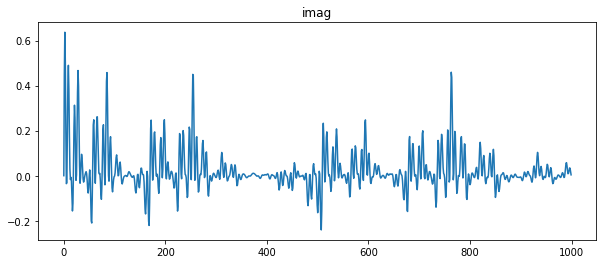

In [ ]:
data3 = cantor_gen(10000, 15)
plot_2d_complex2(lambda x : empchar(data3, x), xs=ts)

Empiryczna funkcja charakterystyczna dla precyzji równej 1

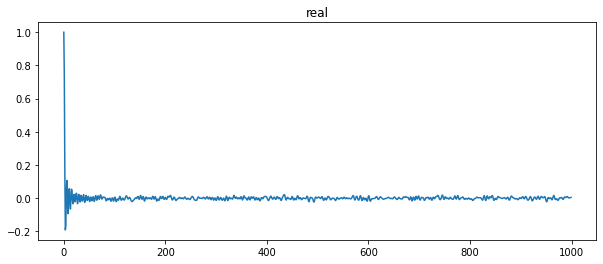

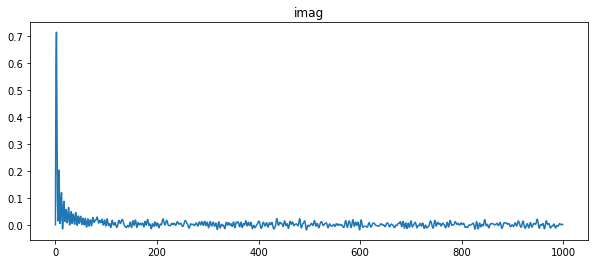

In [ ]:
data4 = cantor_gen(10000, 1)
plot_2d_complex2(lambda x : empchar(data4, x), xs=ts)

## Uogólnienie generatora


Poprzedni generator liczb z rozkładu Cantora opierał się na liczbach w systemie trójkowym, w uogólnionym wzórze zapisanym poniżej $p$ jest dowolną liczbą.

$$x = \sum_{i=1}^{\infty} \frac{a_i}{p^i}, $$
gdzie $a_i \in \{0,1,\dots, p-1\}.$

In [15]:
def cantor_gen_gen(a_n, n, p, size=10):
    ys = np.zeros(size)
    r = np.random.randint(0, len(a_n), size=(size, n), dtype=int)
    a = a_n[r]
    for i in range(n):
        ys = np.add(ys, a[:, i]/(p**i))
    return ys

### Przykład 1
Niech zbiór $A = \{0,1\}$. Zobaczmy jak zmiana samej postawy może wpływać na postać rozkładu.Tutaj $prec=60$, a długość próbki wynosi $1000$.\
Zacznijmy od $p=2$:

In [16]:
ts = np.arange(0, 1000, 1)
data1 = cantor_gen_gen(np.array([0, 1]), 60, 2, 1000)

dystrybuanta:

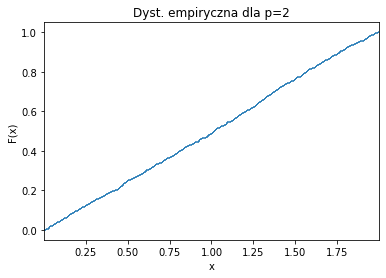

In [17]:
drawdemp(data1, title="Dyst. empiryczna dla p=2")

funkcja charakterystyczna:

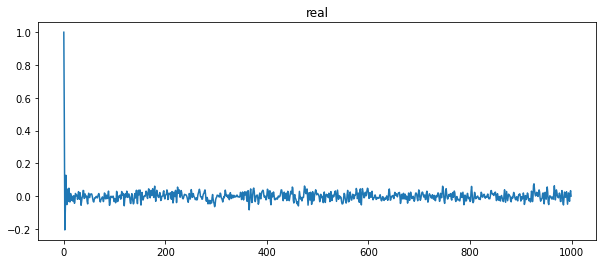

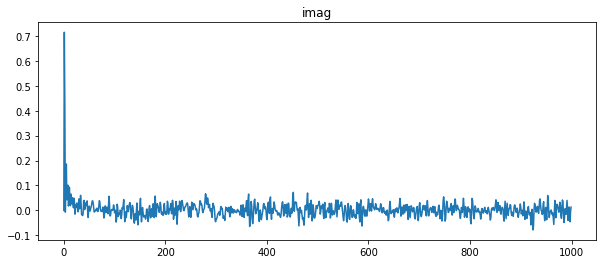

In [18]:
plot_2d_complex2(lambda x : empchar(data1, x), xs=ts)

Takie same wykresy dostajemy zawsze gdy zbiór $A$ zawiera wszystkie możliwe liczby.

Dla podstawy $p=7$:

In [ ]:
data2 = cantor_gen_gen(np.array([0, 1]), 60, 7, 1000)

dystrybuanta:

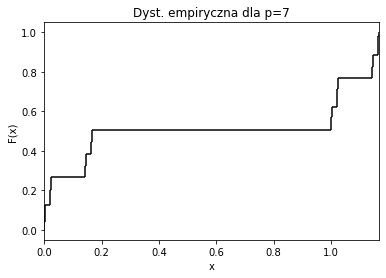

In [ ]:
drawdemp(data2, title="Dyst. empiryczna dla p=7")

funkcja charakterystyczna:

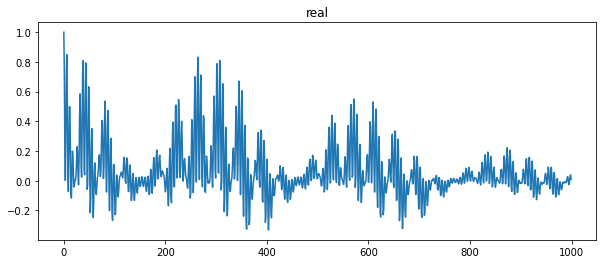

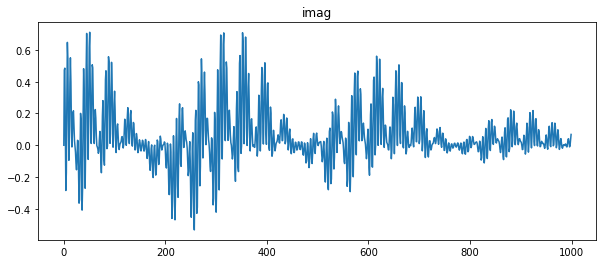

In [ ]:
plot_2d_complex2(lambda x : empchar(data2, x), xs=ts)

Dla podstawy $p = 14$:

In [ ]:
data3 = cantor_gen_gen(np.array([0, 1]), 60, 14, 1000)

dystrybuanta:

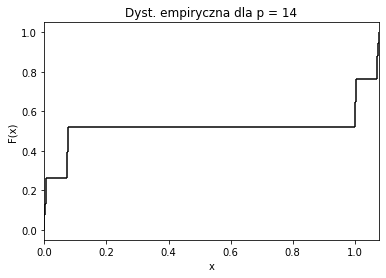

In [ ]:
drawdemp(data3, title="Dyst. empiryczna dla p = 14")

funkcja charakterystyczna:

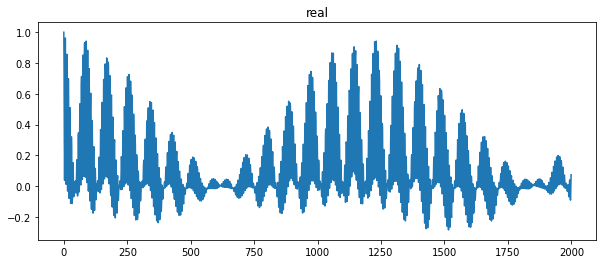

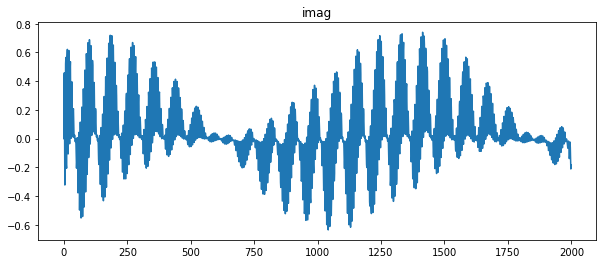

In [ ]:
plot_2d_complex2(lambda x : empchar(data3, x), xs=ts)

Można dojść do wniosku, że dla coraz większych $p$ ilość schodków w dystrybuancie się zmniejsza. Również funkcje charakretystyczne mają bardzo ciekawe wykresy, można zauważyć okresową powtarzalność, stopniowe wygaszenie oraz długość okresu rosnącą wraz z $p$.

### Przykład 2

Ciekawe wykresy otrzymujemy również, gdy zbiór $A$ zawiera tylko jedną wartość. Na przykład dla $p = 6$ i $A = \{3\}$ otrzymujemy:

In [ ]:
data4 = cantor_gen_gen(np.array([3]), 60, 6, 1000)
print(data4[0:10])

[3.600000000000001 3.600000000000001 3.600000000000001 3.600000000000001
 3.600000000000001 3.600000000000001 3.600000000000001 3.600000000000001
 3.600000000000001 3.600000000000001]


Wszystkie wygenerowane liczby są równe, zatem dystrybuanta ma tylko jeden schodek.


Funkcja charakterystyczna jest wyraźnie okresowa oraz w przeciwieństwie do poprzednich wykresów jej amplituda jest stała. Wykresy części rzeczywistej oraz urojonej są przesunięte względem siebie i mają tą samą amplitude.

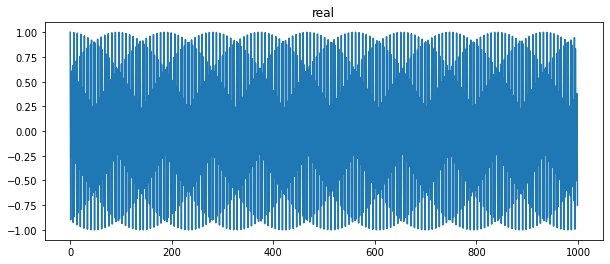

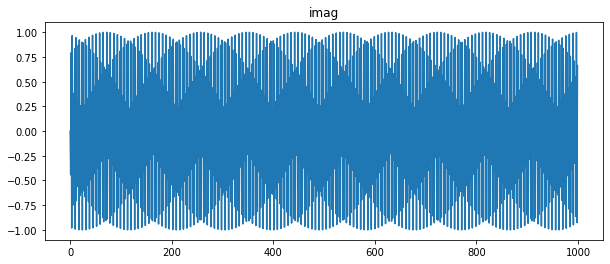

In [ ]:
plot_2d_complex2(lambda x : empchar(data3, x), xs=ts)

### Przykład 3

Zobaczmy jak zmieniają się generowane liczby, gdy będziemy manipulować zbiorem $A$. Niech $p = 12.$

$A = \{0,2\}$

In [ ]:
data5 = cantor_gen_gen(np.array([0,2]), 60, 12, 1000)

dystrybuanta:

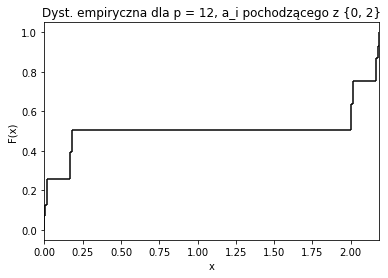

In [ ]:
drawdemp(data5, title="Dyst. empiryczna dla p = 12, a_i pochodzącego z {0, 2}")

funkcja charakterystyczna:

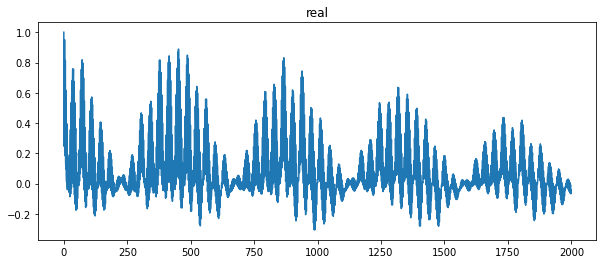

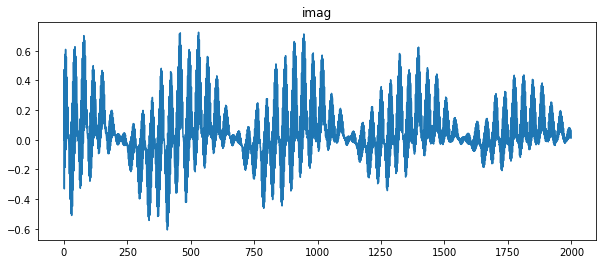

In [ ]:
plot_2d_complex2(lambda x : empchar(data5, x), xs=ts)

$A = \{0, 5\}$

In [ ]:
data6 = cantor_gen_gen(np.array([0, 5]), 60, 12, 1000)

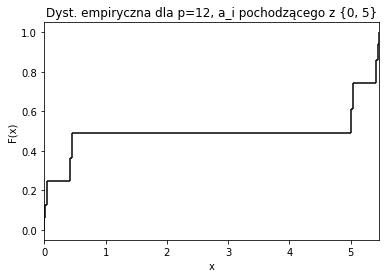

In [ ]:
drawdemp(data6, title="Dyst. empiryczna dla p=12, a_i pochodzącego z {0, 5}")

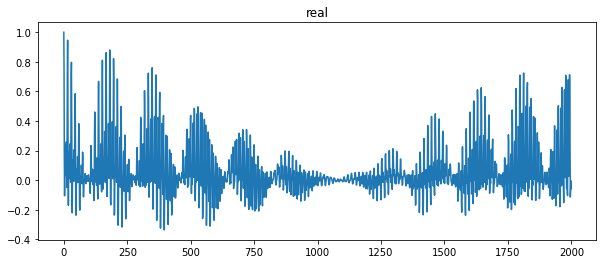

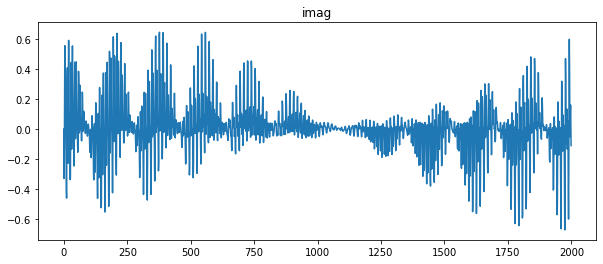

In [ ]:
plot_2d_complex2(lambda x : empchar(data6, x), xs=ts)

$A = \{0,2,11\}$

In [ ]:
data7 = cantor_gen_gen(np.array([0, 2, 11]), 60, 12, 1000)

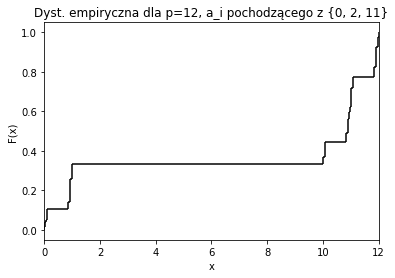

In [ ]:
drawdemp(data7, title="Dyst. empiryczna dla p=12, a_i pochodzącego z {0, 2, 11}")

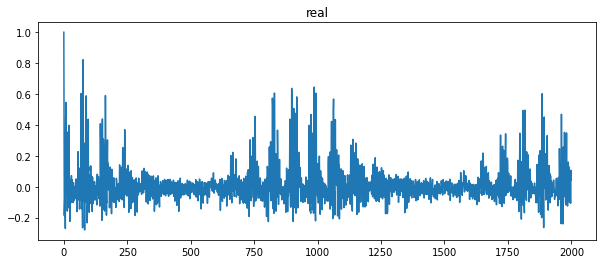

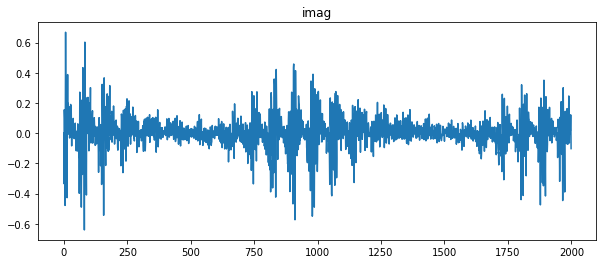

In [ ]:
plot_2d_complex2(lambda x : empchar(data7, x), xs=ts)

$A = \{0,10,11\}$

In [ ]:
data8 = cantor_gen_gen(np.array([0, 10, 11]), 60, 12, 1000)

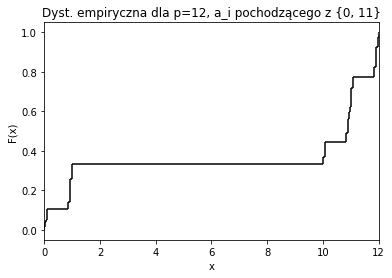

In [ ]:
drawdemp(data8, title="Dyst. empiryczna dla p=12, a_i pochodzącego z {0, 10, 11}")

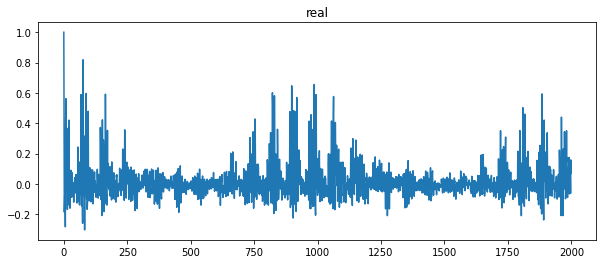

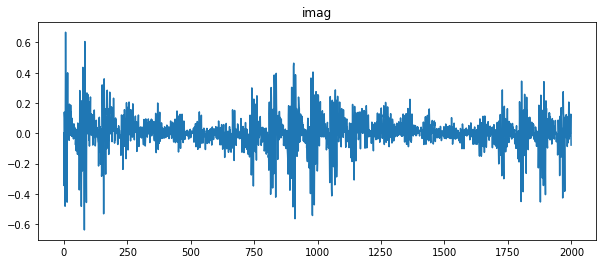

In [ ]:
plot_2d_complex2(lambda x : empchar(data8, x), xs=ts)

Porównując wykresy dystrybuant dla $A = \{0, 2, 11\}$ oraz $A = \{0, 10, 11\}$ można zauważyć wyraźną zależność pomiędzy wartościami zbioru $A$, a dysrtybuantą empiryczną. Mianowicie skoki pojawiają się w okolicach wartości $a_i, a_2, a_3$. Ponadto ilość elementów zbioru jest wprost proporcjonalna do ilości schodków.

### Przykład 4

Na koniec spójrzmy na wykresy dla liczniejszych zbiorów $A$.

In [ ]:
data9 = cantor_gen_gen(np.array([0, 3, 7, 9, 11]), 60, 12, 1000)

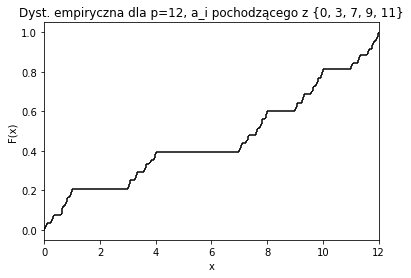

In [ ]:
drawdemp(data9, title="Dyst. empiryczna dla p=12, a_i pochodzącego z {0, 3, 7, 9, 11}")

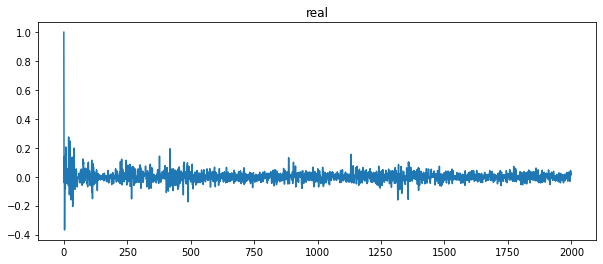

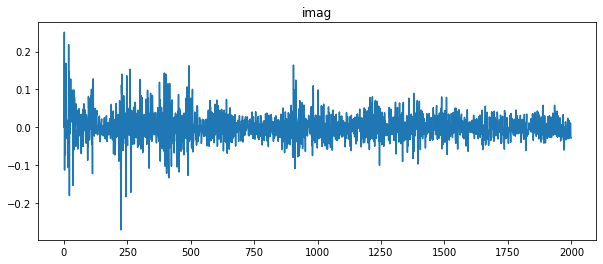

In [ ]:
plot_2d_complex2(lambda x : empchar(data9, x), xs=ts)

Wykresy funkcji charakterystycznych są bardzo chaotyczne.

## Wnioski
Funkcja Cantora jest typowym przykładem funkcji osobliwej, ciekawie wiąże się ona z różnymi sposobami reprezentacji liczb. Udało nam się przedstawić wizualizacje singularnego rozkładu Cantora oraz zdobyć głębsze zrozumienie generowania zmiennych z tego rozkładu. Mogłyśmy również zaboserować zachowanie uogólnionej funkcji Cantora dla różnych wartości parametrów.